## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
import random
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.data.dataset import PerthTempAndRainfall
from ts.utility import Utility, Metric
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso
from ts.plot import Plot

## Load Dataset

In [2]:
rainfall_df = PerthTempAndRainfall.loadData('/Users/ahmed/Downloads/Datasets/PerthTempAndRainfall')
rainfall_df

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality,Date
0,1944.0,6.0,3.0,11.0,22.3,0.0,N,1944-06-03
1,1944.0,6.0,4.0,12.2,23.4,0.0,Y,1944-06-04
2,1944.0,6.0,5.0,12.0,20.3,2.0,Y,1944-06-05
3,1944.0,6.0,6.0,7.4,18.7,3.3,Y,1944-06-06
4,1944.0,6.0,7.0,5.9,21.3,0.3,Y,1944-06-07
...,...,...,...,...,...,...,...,...
27642,1991.0,6.0,23.0,NaN,18.6,25.4,Y,None
27643,1997.0,1.0,1.0,NaN,43.5,0.0,Y,None
27644,1999.0,8.0,11.0,NaN,15.4,31.4,Y,None
27645,2018.0,5.0,26.0,NaN,18.8,27.4,N,None


In [3]:
rainfall_df.drop(range(27540, len(rainfall_df)), inplace=True)
rainfall_df.reset_index(inplace=True)
rainfall_df

,index,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality,Date
0,0,1944.0,6.0,3.0,11.0,22.3,0.0,N,1944-06-03
1,1,1944.0,6.0,4.0,12.2,23.4,0.0,Y,1944-06-04
2,2,1944.0,6.0,5.0,12.0,20.3,2.0,Y,1944-06-05
3,3,1944.0,6.0,6.0,7.4,18.7,3.3,Y,1944-06-06
4,4,1944.0,6.0,7.0,5.9,21.3,0.3,Y,1944-06-07
...,...,...,...,...,...,...,...,...,...
27535,27535,2020.0,2.0,5.0,25.2,36.4,0.0,N,2020-02-05
27536,27536,2020.0,2.0,6.0,21.0,32.6,0.0,N,2020-02-06
27537,27537,2020.0,2.0,7.0,20.7,30.6,0.0,N,2020-02-07
27538,27538,2020.0,2.0,8.0,19.6,28.2,0.0,N,2020-02-08


### Get Rainfall Series

In [4]:
rainfall_series = rainfall_df['Rainfall amount (millimetres)'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}, '
    + f'Contains NaN: {np.isnan(rainfall_series).any()}')

Rainfall data: datatype: float64, shape: (27540,), Contains NaN: False


In [5]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = datetime.date(
        int(row.Year), int(row.Month), int(row.Day)
    )
    
date_series = np.array(date_series)

## Train-Test Split

In [6]:
train_frac = 0.90
num_train = int(n * train_frac)

print(f'Length of training series: {num_train}, '
     + f'Length of test series: {n - num_train}')

Length of training series: 24786, Length of test series: 2754


### Plot Entire Data

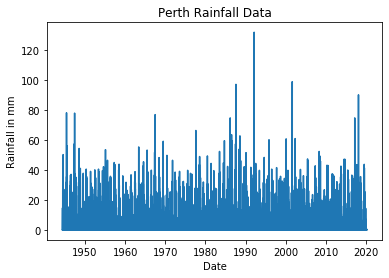

In [7]:
plt.plot(date_series, rainfall_series)
plt.title('Perth Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

### All Data Histogram

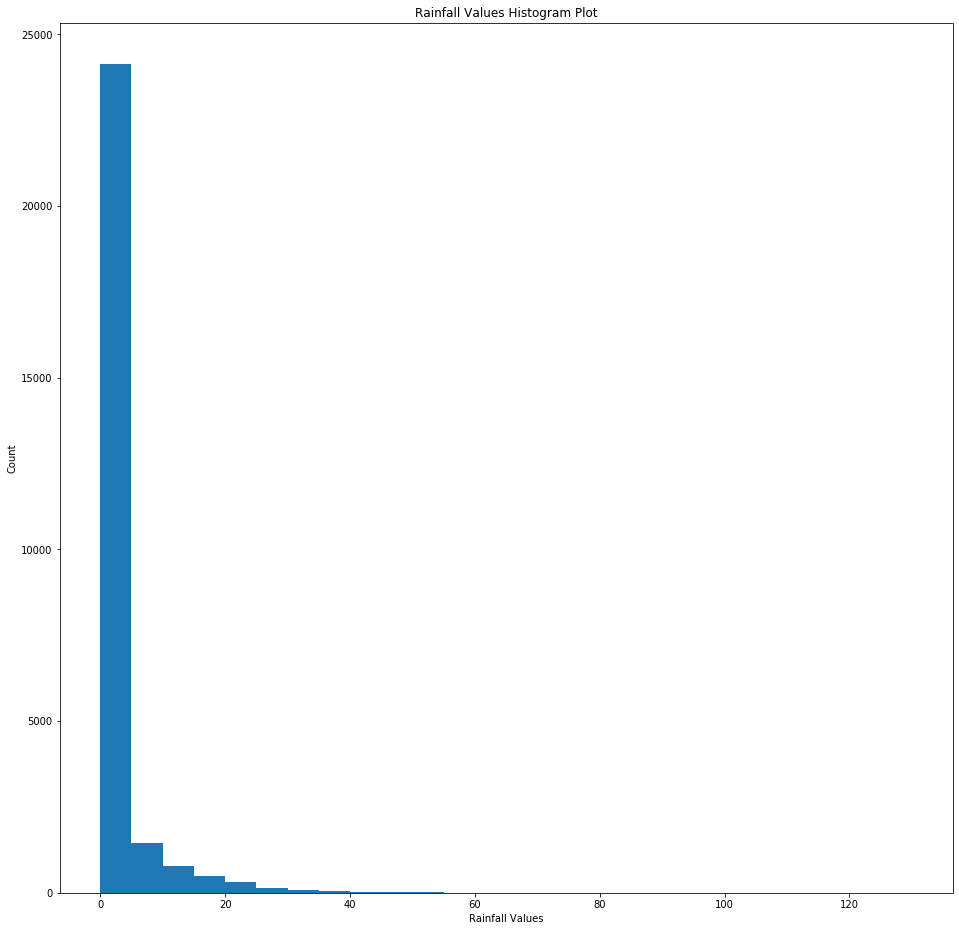

In [8]:
bin_width = 5
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

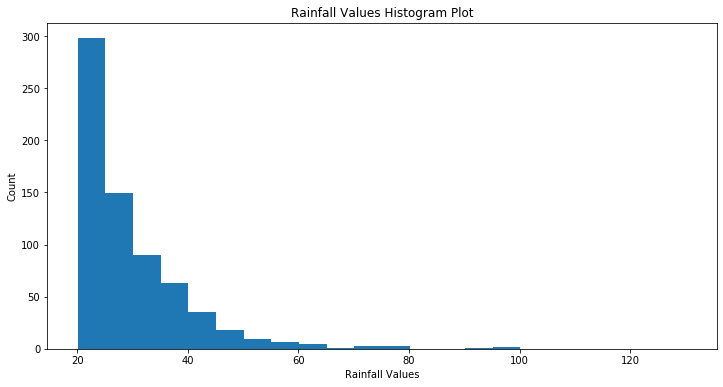

In [9]:
lower_bound = 20

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 5
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

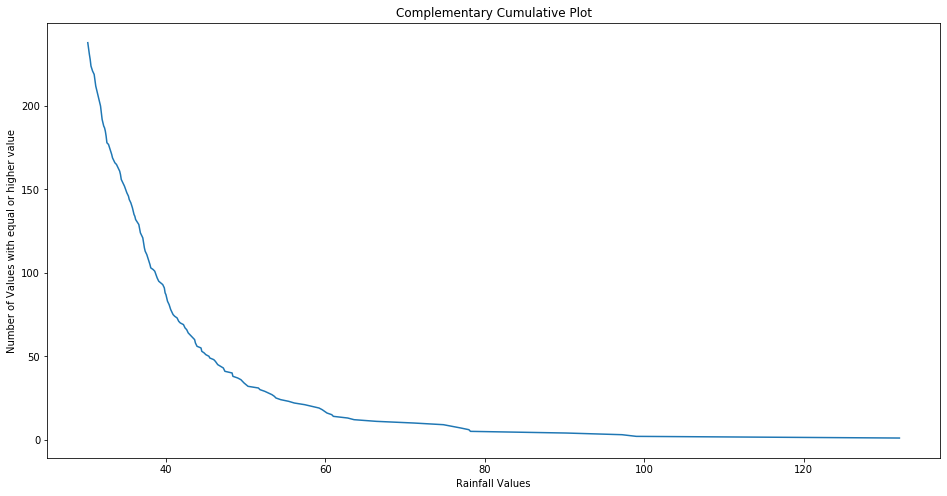

In [10]:
lower_bound = 30

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [11]:
threshold = 30 # Rainfall in mm

exceed_series = []

for i in range(num_train):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (213,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.1431377574839604 
Scale Parameter: 9.225623789414689 
Log Likelihood: -716.7711062535881


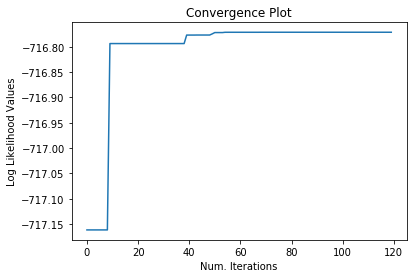

In [12]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 200),
    numIterations=120
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [13]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

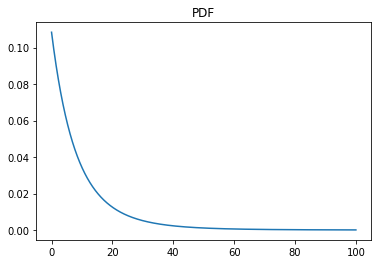

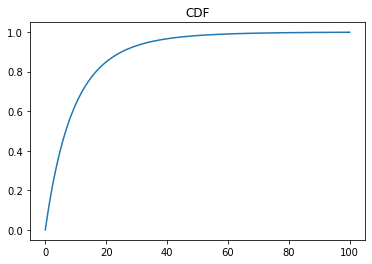

In [14]:
x = np.linspace(0, 100, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [15]:
lag = 20

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [16]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (213, 20)
Output Data: datatype: float64, shape: (213, 1)


In [17]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4,  5.1, 19.3,
         0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. ],
       [ 0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. , 41.4,  1.8,  2.5,  0. ,
         3.8,  0.5,  0.5,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , 41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,
         0.3,  0. ,  0. ,  0. ,  0. ,  0. , 34.3,  0.8,  0. ],
       [ 0. , 34.3,  0.8,  0. , 34.3,  6.1, 10.9,  0.8,  5.6,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0.3,  0. ,  0. ,  0. ,  2. ,  0.8,  5.8,  0.5,  0. ,  0. ,
         0. ,  0. ,  0. ,  3.6,  4.8,  0. ,  0. ,  0.8,  0.8]])

First few outputs:
array([[0.67947525],
       [0.36313908],
       [0.36313908],
       [0.85234588],
       [0.17505124]])

Last few inputs:
array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.6,  

### Train the Model

Epoch 1/100
7/7 [==============================] - 0s 953us/step - loss: 0.1382
Epoch 2/100
7/7 [==============================] - 0s 973us/step - loss: 0.0820
Epoch 3/100
7/7 [==============================] - 0s 922us/step - loss: 0.0791
Epoch 4/100
7/7 [==============================] - 0s 814us/step - loss: 0.0764
Epoch 5/100
7/7 [==============================] - 0s 801us/step - loss: 0.0763
Epoch 6/100
7/7 [==============================] - 0s 781us/step - loss: 0.0721
Epoch 7/100
7/7 [==============================] - 0s 859us/step - loss: 0.0674
Epoch 8/100
7/7 [==============================] - 0s 882us/step - loss: 0.0678
Epoch 9/100
7/7 [==============================] - 0s 817us/step - loss: 0.0699
Epoch 10/100
7/7 [==============================] - 0s 814us/step - loss: 0.0639
Epoch 11/100
7/7 [==============================] - 0s 800us/step - loss: 0.0600
Epoch 12/100
7/7 [==============================] - 0s 823us/step - loss: 0.0558
Epoch 13/100
7/7 [===================

7/7 [==============================] - 0s 798us/step - loss: 4.5467e-04


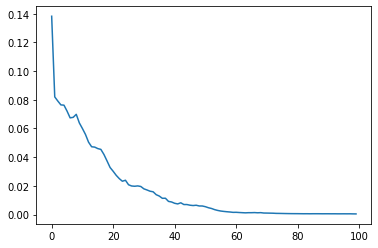

In [18]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [19]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (25, 20)
Output Test Data: datatype: float64, shape: (25, 1)

Test Loss (CDF): 0.09023206681013107
Test Loss (Actual): 222.92893981933594


## Part 2: Extreme Value Detection (Classification) Algorithm

In [20]:
class MlpEnsemble:
    
    def get_model(self, lag):
        
        model = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        
        model.build(input_shape=(None, lag))
        model.compile(
            optimizer=Adam(
                ExponentialDecay(
                    1e-3, 50, 0.9
                )
            ),
            loss=BinaryCrossentropy(from_logits=True)
        )
        
        return model
    
    def __init__(self, lag, num_models=10, neg_data_ratio=1.0):
        
        self.models = [self.get_model(lag) for _ in range(num_models)]
        self.neg_data_ratio = neg_data_ratio
        
    def train(self, input_data, output_data, each_model_epochs):
        
        pos_data = []
        neg_data = []
        
        for i in range(input_data.shape[0]):
            
            if output_data[i, 0] == 1:
                pos_data.append((input_data[i], output_data[i]))
                
            else:
                neg_data.append((input_data[i], output_data[i]))
        
        assert len(pos_data) < len(neg_data)
        
        losses = np.zeros(each_model_epochs)
        num_neg_to_take = int(len(pos_data) * self.neg_data_ratio)
        
        for model in self.models:
            
            data = pos_data.copy()
            data.extend(random.sample(neg_data, k=num_neg_to_take))
            
            input_data, output_data = [], []
            for inp, out in data:
                input_data.append(inp)
                output_data.append(out)
                
            input_data = np.array(input_data)
            output_data = np.array(output_data)
        
            history = model.fit(
                input_data, 
                output_data, 
                epochs=each_model_epochs,
                verbose=0
            )
            
            losses += np.array(history.history['loss'])
                
        losses /= len(self.models)
        return losses
    
    def predict(self, input_data):
        
        num_pos = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        num_neg = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        
        for model in self.models:
            
            model_out = model.predict(input_data)
            model_pred = (tf.sigmoid(model_out).numpy() > 0.5) \
                .astype(np.int64)
            
            num_pos += model_pred
            num_neg += (1 - model_pred)
            
        pred = (num_pos > num_neg).astype(np.int64)
        return pred

In [21]:
model_detect = MlpEnsemble(lag=lag, num_models=10, neg_data_ratio=2.)

### Build Training Data

In [22]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1)
    
    else:
        output_data.append(0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (24766, 20)
Output Data: datatype: int64, shape: (24766, 1)


In [23]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,
         0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4]])

First few outputs:
array([[0],
       [0],
       [0],
       [0],
       [0]])

Last few inputs:
array([[0. , 0. , 0. , 0. , 0. , 0. , 6.8, 0. , 0. , 6.6, 3.8, 0. , 0. ,
        0. , 0. , 0.8, 7. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 6.8, 0. , 0. , 6.6, 3.8, 0. , 0. , 0. ,
       

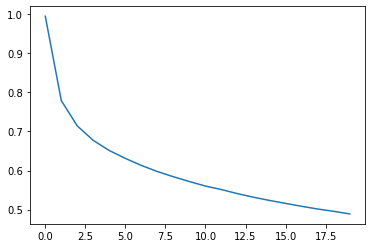

In [24]:
losses = model_detect.train(input_data, output_data, 20)
plt.plot(losses)

In [25]:
is_pos = output_data == 1.

num_true_pos = np.sum(model_detect.predict(input_data)[is_pos])
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(1 - model_detect.predict(input_data)[is_neg])
total_neg = np.sum(is_neg)

print(f'Train: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Train: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Train: True Pos: 112, Total Pos: 213
Train: True Neg: 22507, Total Neg: 24553


## Part 3: Normal Value Prediction Algorithm

In [26]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [27]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (24553, 20)
Output Data: datatype: float64, shape: (24553, 1)


In [28]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,
         0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4]])

First few outputs:
array([[ 0. ],
       [ 0. ],
       [ 0. ],
       [11.4],
       [ 5.1]])

Last few inputs:
array([[0. , 0. , 0. , 0. , 0. , 0. , 6.8, 0. , 0. , 6.6, 3.8, 0. , 0. ,
        0. , 0. , 0.8, 7. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 6.8, 0. , 0. , 6.6, 3.8, 0. , 0.

Epoch 1/20
768/768 [==============================] - 1s 726us/step - loss: 18.6758
Epoch 2/20
768/768 [==============================] - 1s 914us/step - loss: 17.8756
Epoch 3/20
768/768 [==============================] - 1s 654us/step - loss: 17.7163
Epoch 4/20
768/768 [==============================] - 1s 687us/step - loss: 17.6664
Epoch 5/20
768/768 [==============================] - 0s 641us/step - loss: 17.6556
Epoch 6/20
768/768 [==============================] - 1s 670us/step - loss: 17.6533
Epoch 7/20
768/768 [==============================] - 1s 749us/step - loss: 17.6528
Epoch 8/20
768/768 [==============================] - 1s 657us/step - loss: 17.6527
Epoch 9/20
768/768 [==============================] - 0s 645us/step - loss: 17.6527
Epoch 10/20
768/768 [==============================] - 1s 654us/step - loss: 17.6526
Epoch 11/20
768/768 [==============================] - 0s 643us/step - loss: 17.6527
Epoch 12/20
768/768 [==============================] - 0s 649us/step - los

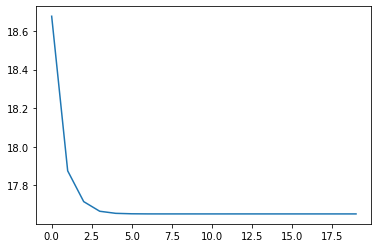

In [29]:
history = model_normal.fit(input_data, output_data, epochs=20)
plt.plot(history.history['loss'])

## Compute Test Loss

In [30]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (2729, 20)
Output Test Data: datatype: float64, shape: (2729, 1)

Test Loss: 16.58927345275879


# Combining Algorithms

## Forecasting Training Data

In [31]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (24766, 20)
Output Test Data: datatype: float64, shape: (24766, 1)



In [32]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]

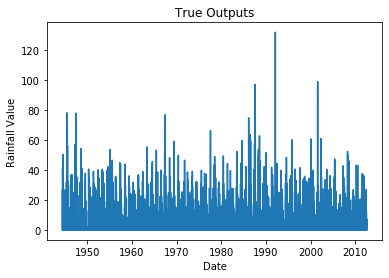

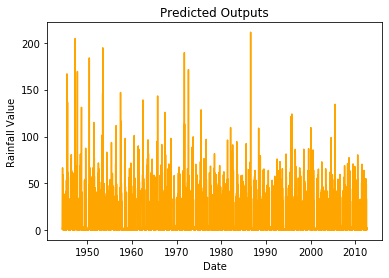

In [33]:
plt.plot(date_series[lag: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[lag: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

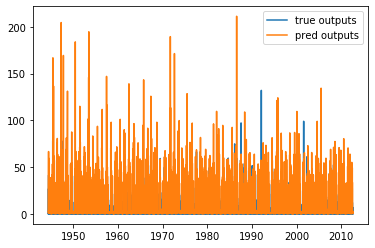

In [34]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

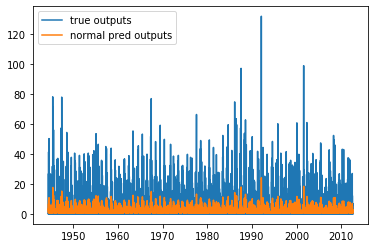

In [35]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

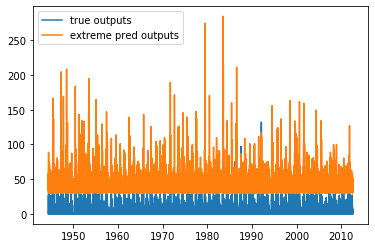

In [36]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

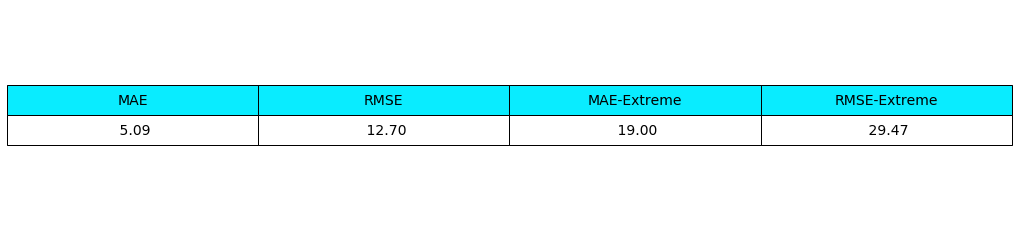

In [37]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

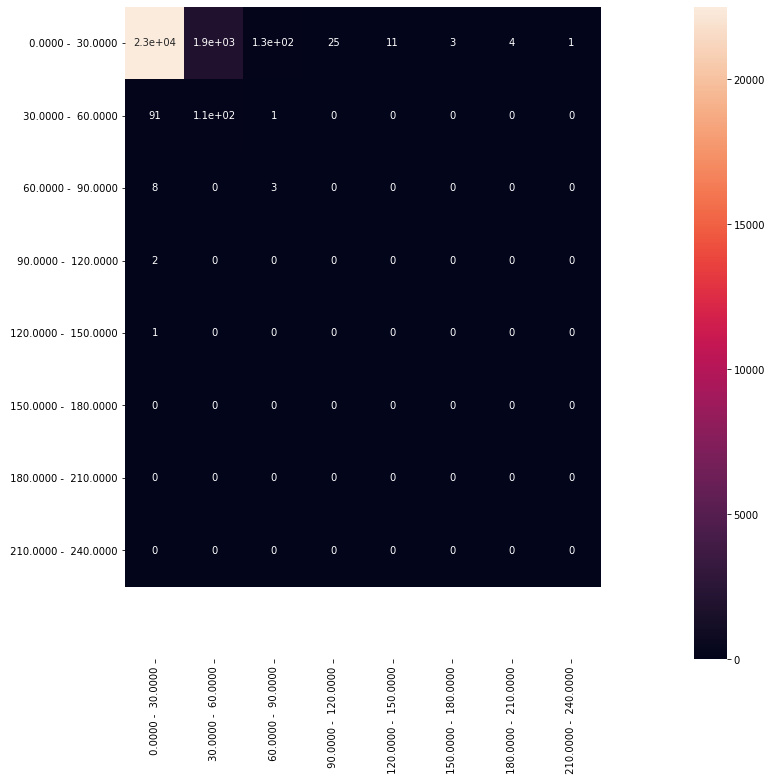

In [38]:
Plot.plotConfusionMatrix(
    np.squeeze(output_data, axis=1), 
    np.squeeze(pred_outputs, axis=1), 
    30, 4
)

## Forecasting Test Data

In [39]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (2754, 20)
Output Test Data: datatype: float64, shape: (2754, 1)



In [40]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]

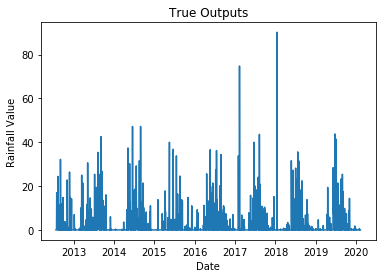

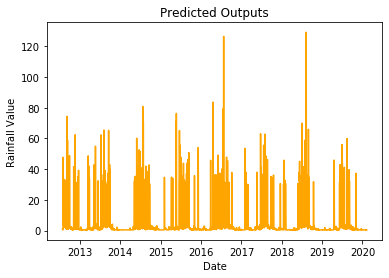

In [41]:
plt.plot(date_series[num_train:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

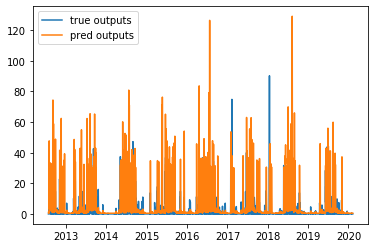

In [42]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

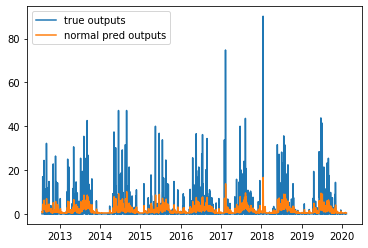

In [43]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

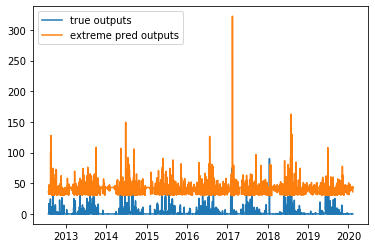

In [44]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

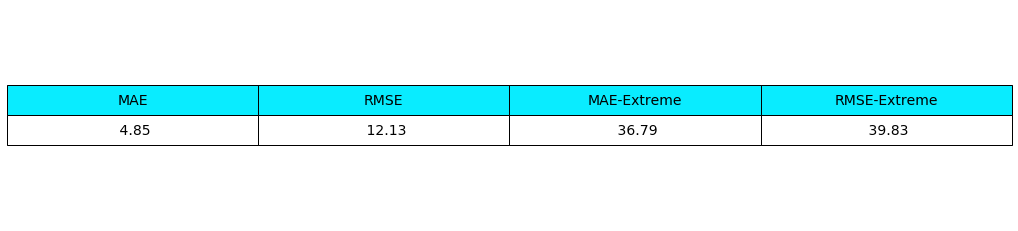

In [45]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

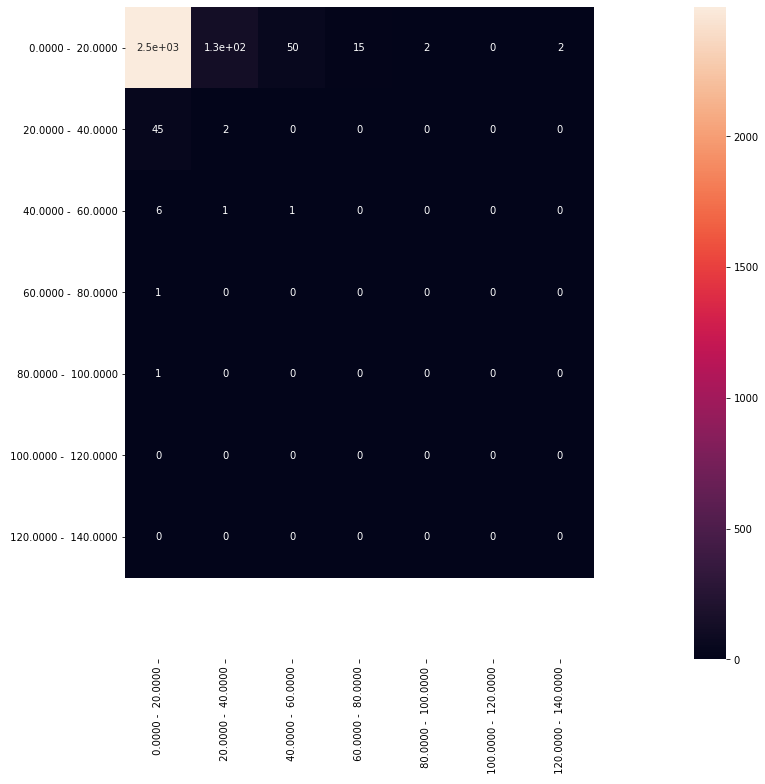

In [46]:
Plot.plotConfusionMatrix(
    np.squeeze(output_data, axis=1), 
    np.squeeze(pred_outputs, axis=1), 
    20, 4
)